In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import layers,models

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# function to plot the analytics
def graphs(loss_history,loss_history_test,train_acc_history,val_acc_history,lr_array,name,compare=False,n=2,labels=[]):
    lists=[loss_history,loss_history_test,train_acc_history,val_acc_history,lr_array]
    titiles=["training loss","testing loss","training accuracy","testing accuracy","Learning Rate"]
    fig,ax=plt.subplots(1,5,figsize=(25,5))
    for i in range(len(lists)):
        if compare:
            for j in range(n):
                ax[i].plot(lists[i][j],label=labels[j])
            ax[i].legend()  
        else:
            ax[i].plot(lists[i])
        ax[i].set_ylabel(titiles[i])
        ax[i].set_xlabel("epoch")
        ax[i].plot()
    fig.savefig(fname="metrics_"+name+".png",transparent=True)
    return None

In [3]:
# Defining function for data preprocessing
def preprocess(norm,reshape):
    # Importing data set CIFAR-10
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    K = len(np.unique(y_train)) # no.of Classes 
    Ntr = x_train.shape[0] # Number of training data=50,000
    Nte = x_test.shape[0] # Number of testing data=10,000
    Din =  x_train.shape[1]*x_train.shape[2]*x_train.shape[3]  # CIFAR10 

    if norm:
        x_train, x_test = x_train / 255.0, x_test / 255.0# Normalize pixel values

    # Center the pixel values
    mean_image = np.mean(x_train, axis=0)
    x_train = x_train - mean_image
    x_test = x_test - mean_image

    y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

    #flatterning the input images
    if reshape:
        x_train = np.reshape(x_train,(Ntr,Din))
        x_test = np.reshape(x_test,(Nte,Din))
    # Changing the data types
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    return x_train,y_train,x_test,y_test,K,Din,Ntr,Nte

In [4]:
# Defining linear Classifier function
def linear_classifier(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg,Ntr,Nte):
    batch_size = Ntr
    loss_history = []
    loss_history_testing = []
    train_acc_history = []
    val_acc_history = []
    lr_array=[]
    seed = 0
    rng = np.random.default_rng(seed=seed)

    # Initializing weight and bias arrays
    std=1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    for t in range(iterations):
       # shuffling the training data set to randomize the training process for prevent overfitting
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]
       # forward propagation
        y_pred=x.dot(w1)+b1
        y_pred_test=x_test.dot(w1)+b1
        val=y_pred_test.shape[0]
        # calculating loss using regularized loss function
        train_loss=(1/batch_size)*(np.square(y_pred-y)).sum()+reg*(np.sum(w1*w1))
        loss_history.append(train_loss)
        test_loss=(1/val)*(np.square(y_pred_test-y_test)).sum()+reg*(np.sum(w1*w1))
        loss_history_testing.append(test_loss)
        # calculating accuracy
        train_accuracy=1-(1/(10*batch_size))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
        train_acc_history.append(train_accuracy)
        test_accuracy=1-(1/(10*Nte))*(np.abs(np.argmax(y_test,axis=1)-np.argmax(y_pred_test,axis=1))).sum()
        val_acc_history.append(test_accuracy)

        if t%10 == 0:
            print('epoch %d/%d: train loss= %f || ,test loss= %f ||,train accuracy= %f ||, test accuracy= %f ||, learning rate= %f ||' 
            % (t,iterations,train_loss,test_loss,train_accuracy,test_accuracy,lr))
        # Backward propagation
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw1=x.T.dot(dy_pred)+reg*w1
        db1=dy_pred.sum(axis=0)
        # updating parameters
        w1-=lr*dw1
        b1-=lr*db1
        lr_array.append(lr)
        lr*=lr_decay
    return w1,b1,loss_history,loss_history_testing,train_acc_history,val_acc_history,lr_array

In [30]:
#defining parameters and run the linear classifier
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lambda=regularization constant for the loss function
x_train,y_train,x_test,y_test,K,Din,Ntr,Nte=preprocess(norm=True,reshape=True)

w1,b1,loss_history,loss_history_test,train_acc_history,val_acc_history,lr_array=linear_classifier(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg,Ntr,Nte)

epoch 0/300: train loss= 1.000032 || ,test loss= 1.000029 ||,train accuracy= 0.659352 ||, test accuracy= 0.663690 ||, learning rate= 0.014000 ||
epoch 10/300: train loss= 0.876638 || ,test loss= 0.876236 ||,train accuracy= 0.756496 ||, test accuracy= 0.758180 ||, learning rate= 0.013861 ||
epoch 20/300: train loss= 0.842540 || ,test loss= 0.842416 ||,train accuracy= 0.762686 ||, test accuracy= 0.767750 ||, learning rate= 0.013723 ||
epoch 30/300: train loss= 0.823616 || ,test loss= 0.823714 ||,train accuracy= 0.766500 ||, test accuracy= 0.770390 ||, learning rate= 0.013586 ||
epoch 40/300: train loss= 0.812389 || ,test loss= 0.812706 ||,train accuracy= 0.768626 ||, test accuracy= 0.771560 ||, learning rate= 0.013451 ||
epoch 50/300: train loss= 0.805426 || ,test loss= 0.805969 ||,train accuracy= 0.770386 ||, test accuracy= 0.772880 ||, learning rate= 0.013317 ||
epoch 60/300: train loss= 0.800906 || ,test loss= 0.801678 ||,train accuracy= 0.771582 ||, test accuracy= 0.773460 ||, learni

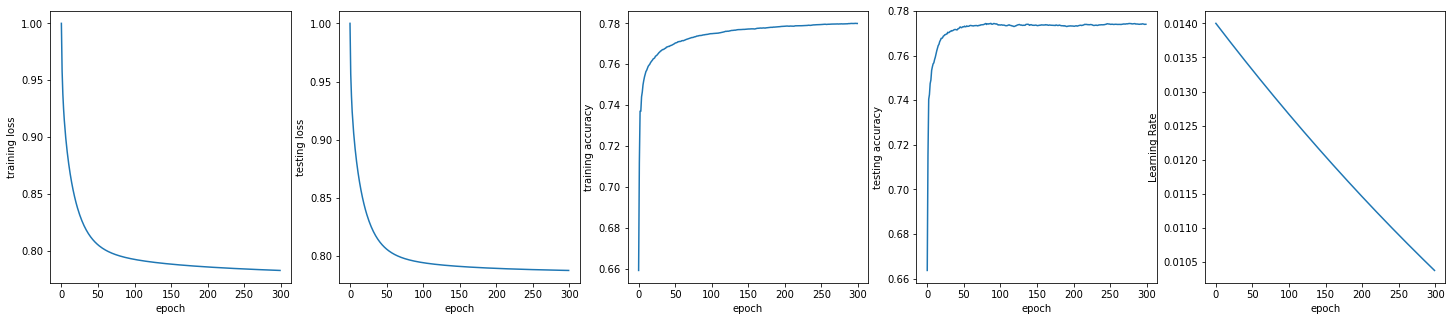

In [31]:
#plotting graphs
graphs(loss_history,loss_history_test,train_acc_history,val_acc_history,lr_array,"linear classifier")

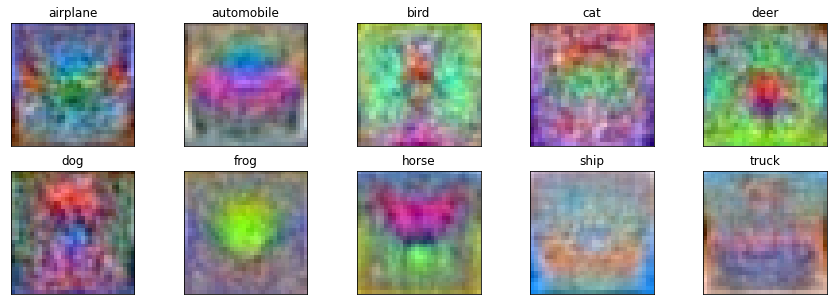

In [32]:
#plotting the weight matrix W as 10 images
images=[]
titles=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(w1.shape[1]):
    temp=np.reshape(w1[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
fig,ax=plt.subplots(2,5,figsize=(15,5))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(titles[i*5+j])
plt.show()
fig.savefig("w1_images.png",transparent=True)

In [7]:
#part2
def layer_2(x_train,y_train,x_test,y_test,Din,lr,lr_decay,H,reg,K,Ntr,Nte):
    loss_history = []
    loss_history_test = []
    train_acc_history = []
    val_acc_history = []
    lr_array =[]
    seed = 0
    rng = np.random.default_rng(seed=seed)
    batch_size=Ntr

    std=1e-5
    #initializing weight and bias matrices for hidden layer
    w1 = std*np.random.randn(Din, H)
    b1 = np.zeros(H)
    #initializing weight and bias matrices for final layer
    w2 = std*np.random.randn(H, K)
    b2 = np.zeros(K)

    for t in range(iterations):
        indices = np.arange(Ntr)
        
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]

        #forward propagation
        h=1/(1+np.exp(-(x.dot(w1)+b1)))
        h_test=1/(1+np.exp(-((x_test).dot(w1)+b1)))
        y_pred=h.dot(w2)+b2
        y_pred_test=h_test.dot(w2)+b2
        val=y_pred_test.shape[0]
        # calculating the training and testing loss
        training_loss=(1/batch_size)*(np.square(y_pred-y)).sum()+reg*(np.sum(w1*w1)+np.sum(w2*w2))
        loss_history.append(training_loss)
        testing_loss=(1/val)*(np.square(y_pred_test-y_test)).sum()+reg*(np.sum(w1*w1)+np.sum(w2*w2))
        loss_history_test.append(testing_loss)
        
        # calculating trainning and testing accuracies
        train_accuracy=1-(1/(10*batch_size))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
        train_acc_history.append(train_accuracy)

        test_accuracy=1-(1/(10*Nte))*(np.abs(np.argmax(y_test,axis=1)-np.argmax(y_pred_test,axis=1))).sum()
        val_acc_history.append(test_accuracy)
        
        if t%10 == 0:
            print('epoch %d/%d: loss= %f || , test loss= %f ||, train accuracy= %f ||, test accuracy= %f ||, learning rate= %f ||' 
            % (t,iterations,training_loss,testing_loss,train_accuracy,test_accuracy,lr))

        # Backward propagation
        # find the deravatives of the learnable parameters
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw2=h.T.dot(dy_pred)+reg*w2
        db2=dy_pred.sum(axis=0)
        dh=dy_pred.dot(w2.T)
        dw1=x.T.dot(dh*h*(1-h))+reg*w1
        db1=(dh*h*(1-h)).sum(axis=0)
        #update weight matrices
        w1-=lr*dw1 
        w2-=lr*dw2
        #update bias matrices
        b1-=lr*db1
        b2-=lr*db2
        lr_array.append(lr)
        lr*=lr_decay # learning rate
    return w1,b1,w2,b2,loss_history,loss_history_test,train_acc_history,val_acc_history,lr_array
x_train_2,y_train_2,x_test_2,y_test_2,K,Din,Ntr,Nte=preprocess(norm=False,reshape=True)
#Remove the normalization 
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lambda=regularization parameter
H=200 #hidden layer nodes  
w1_2,b1_2,w2_2,b2_2,loss_history_2,loss_history_test_2,train_acc_history_2,val_acc_history_2,lr_array_2=layer_2(x_train_2,y_train_2,x_test_2,y_test_2,Din,lr,lr_decay,H,reg,K,Ntr,Nte)


epoch 0/300: loss= 0.999993 || , test loss= 0.999993 ||, train accuracy= 0.750000 ||, test accuracy= 0.750000 ||, learning rate= 0.014000 ||
epoch 10/300: loss= 0.864817 || , test loss= 0.864422 ||, train accuracy= 0.718024 ||, test accuracy= 0.719860 ||, learning rate= 0.013861 ||
epoch 20/300: loss= 0.845252 || , test loss= 0.844540 ||, train accuracy= 0.726726 ||, test accuracy= 0.725390 ||, learning rate= 0.013723 ||
epoch 30/300: loss= 0.828879 || , test loss= 0.829004 ||, train accuracy= 0.743068 ||, test accuracy= 0.739930 ||, learning rate= 0.013586 ||
epoch 40/300: loss= 0.818428 || , test loss= 0.818771 ||, train accuracy= 0.752862 ||, test accuracy= 0.753000 ||, learning rate= 0.013451 ||
epoch 50/300: loss= 0.814273 || , test loss= 0.815487 ||, train accuracy= 0.750104 ||, test accuracy= 0.751450 ||, learning rate= 0.013317 ||
epoch 60/300: loss= 0.808094 || , test loss= 0.808975 ||, train accuracy= 0.757374 ||, test accuracy= 0.758490 ||, learning rate= 0.013184 ||
epoch 7

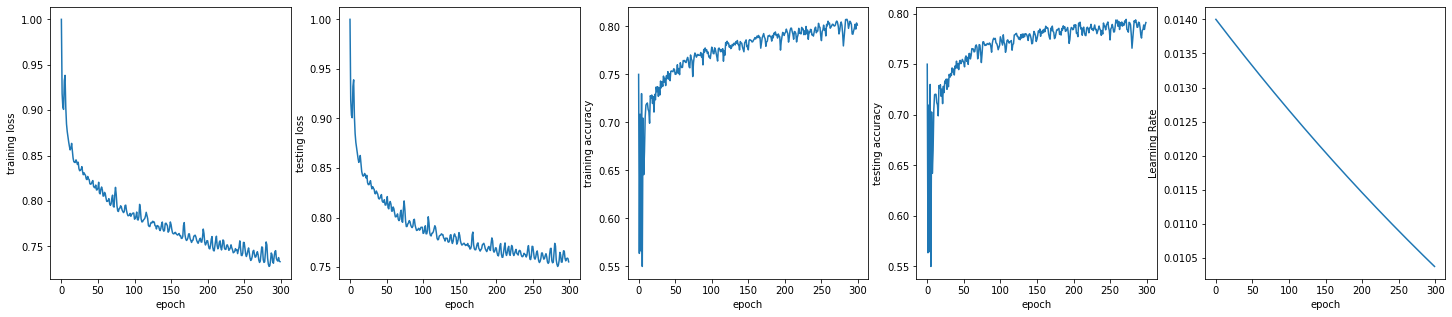

In [8]:
#plotting graphs
graphs(loss_history_2,loss_history_test_2,train_acc_history_2,val_acc_history_2,lr_array_2,"linear classifier")

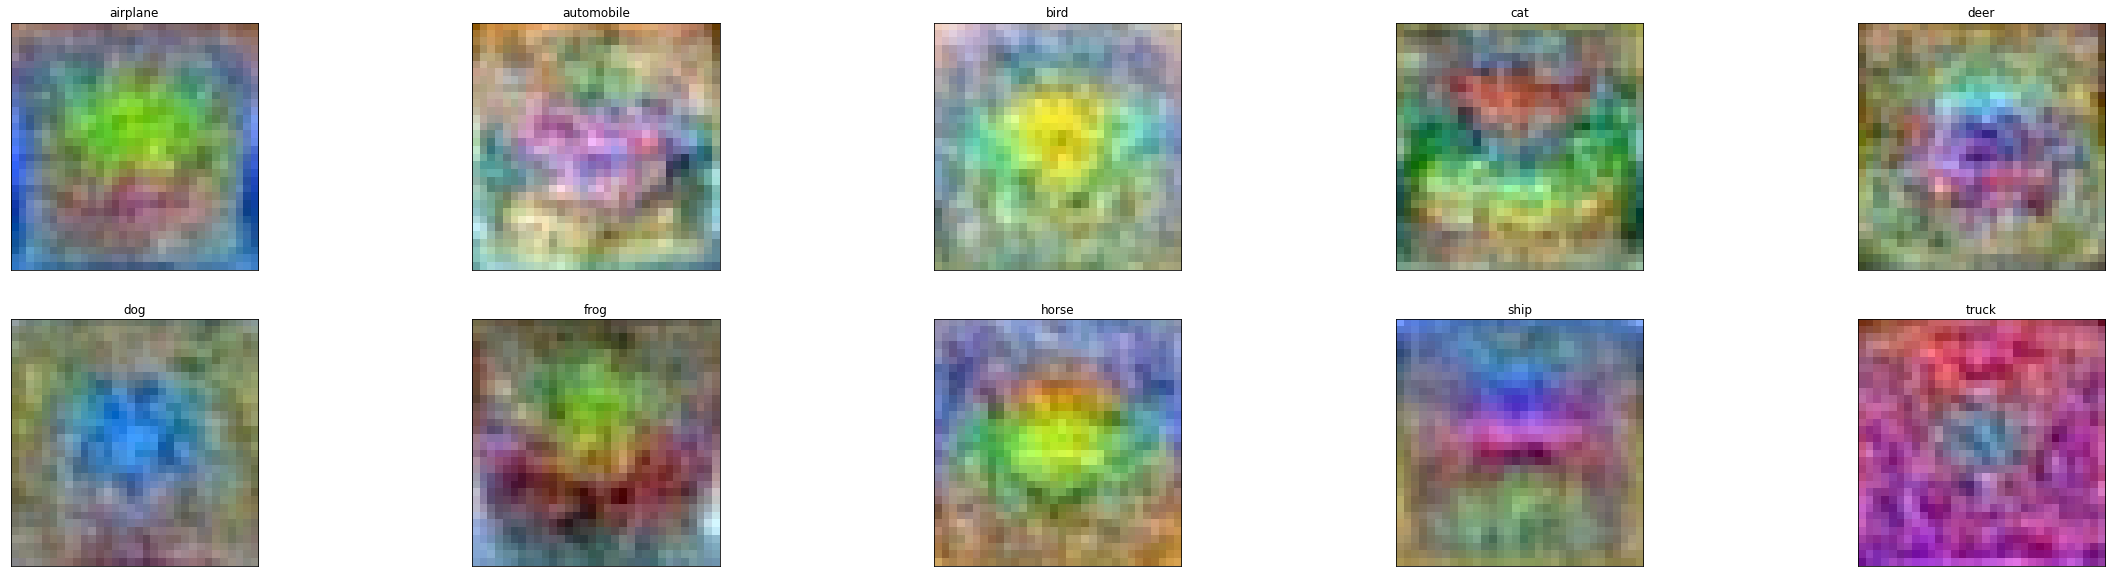

In [9]:
#plotting the weight matrix W as 10 images
images=[]
titles=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(w1_2.shape[1]):
    reshapen=np.reshape(w1_2[:,i]*255,(32,32,3))
    normalized=cv.normalize(reshapen, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(normalized)
fig,ax=plt.subplots(2,5,figsize=(40,10))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(titles[i*5+j])
plt.show()
fig.savefig("w12_images.png",transparent=True)

In [5]:
#part 3
# Function for two layer dense network with stochastic gradient descent
def mini_batching(x_train,y_train,x_test,y_test,Din,lr,lr_decay,H,reg,K,Ntr,Nte):
    loss_history = []
    loss_history_test = []
    train_acc_history = []
    val_acc_history = []
    lr_array =[]
    seed = 0
    rng = np.random.default_rng(seed=seed)
    batch_size=500 #batch size =500 for stochastic gradient descent

    std=1e-5
    #initializing weight and bias matrices for hidden layer
    w1 = std*np.random.randn(Din, H)
    b1 = np.zeros(H)
    #initializing weight and bias matrices for final layer
    w2 = std*np.random.randn(H, K)
    b2 = np.zeros(K)

    for t in range(iterations):
        training_loss = 0
        testing_loss=0
        train_accuracy=0
        test_accuracy=0
        for begin in range(0,Ntr,batch_size):#running 100 groups for each epoch 
            indices = np.arange(Ntr)
            indices=indices[begin:begin+batch_size]#taking only 500 samples
            rng.shuffle(indices)# shuffle the training data set to avoid overfitting 
            x=x_train[indices]
            y=y_train[indices]
            #forward propagation
            h=1/(1+np.exp(-(x.dot(w1)+b1)))
            y_pred=h.dot(w2)+b2
            h_test=1/(1+np.exp(-((x_test).dot(w1)+b1)))
            y_pred_test=h_test.dot(w2)+b2
            val=y_pred_test.shape[0]
            # calculating the training and testing loss for each mini batch
            mini_training_loss=(1/batch_size)*(np.square(y_pred-y)).sum()+reg*(np.sum(w1*w1)+np.sum(w2*w2))
            mini_testing_loss=(1/val)*(np.square(y_pred_test-y_test)).sum()+reg*(np.sum(w1*w1)+np.sum(w2*w2))
            training_loss+= mini_training_loss#updating training loss for each epoch
            testing_loss+= mini_testing_loss#updating testing loss for each epoch

            # calculating trainning and testing accuracies for each mini batch
            mini_train_accuracy=1-(1/(10*batch_size))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
            mini_test_accuracy=1-(1/(10*Nte))*(np.abs(np.argmax(y_test,axis=1)-np.argmax(y_pred_test,axis=1))).sum()
            train_accuracy+=mini_train_accuracy#updating training accuracy for each epoch
            test_accuracy+=mini_test_accuracy#updating testing accuracy for each epoch
            
            # Backward propagation
            #let's find the deravatives of the learnable parameters
            dy_pred=(1./batch_size)*2.0*(y_pred-y)
            dw2=h.T.dot(dy_pred)+reg*w2
            db2=dy_pred.sum(axis=0)
            dh=dy_pred.dot(w2.T)
            dw1=x.T.dot(dh*h*(1-h))+reg*w1
            db1=(dh*h*(1-h)).sum(axis=0)
            #update weight matrices
            w1-=lr*dw1 
            w2-=lr*dw2
            #update bias matrices
            b1-=lr*db1
            b2-=lr*db2
        #taking average of 100 groups to find
        train_accuracy=train_accuracy/(Ntr/batch_size)
        test_accuracy=(test_accuracy/(Ntr/batch_size))
        #taking average of 100 groups to find loss
        training_loss=training_loss/(Ntr/batch_size)
        testing_loss=testing_loss/(Ntr/batch_size)

        loss_history.append(training_loss)
        loss_history_test.append(testing_loss)
        train_acc_history.append(train_accuracy)
        val_acc_history.append(test_accuracy)
        lr_array.append(lr)
        lr*=lr_decay#decaying the learning rate
        # Print for every 10 iterations
        if t%10 == 0:
                print('epoch %d/%d: loss= %f || , test loss= %f ||, train accuracy= %f ||, test accuracy= %f ||, learning rate= %f ||'  
                % (t,iterations,training_loss,testing_loss,train_accuracy,test_accuracy,lr))
    return w1,b1,w2,b2,loss_history,loss_history_test,train_acc_history,val_acc_history,lr_array

In [6]:
batch_size = 500
H=200#hidden layer nodes  
iterations = 300#gradient descent iterations
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6#lambda=regularization parameter
x_train_2,y_train_2,x_test_2,y_test_2,K,Din,Ntr,Nte=preprocess(norm=False,reshape=True)
#Remove the normalization. Otherwise the model will not learn 
w1_batching,b1_batching,w2_batching,b2_batching,loss_history_batching,loss_history_test_batching,train_acc_history_batching,val_acc_history_batching,lr_array_batching=mini_batching(x_train_2,y_train_2,x_test_2,y_test_2,Din,lr,lr_decay,H,reg,K,Ntr,Nte)

epoch 0/300: loss= 0.830486 || , test loss= 0.829334 ||, train accuracy= 0.734268 ||, test accuracy= 0.736599 ||, learning rate= 0.013986 ||
epoch 10/300: loss= 0.712654 || , test loss= 0.754630 ||, train accuracy= 0.813220 ||, test accuracy= 0.791455 ||, learning rate= 0.013847 ||
epoch 20/300: loss= 0.678053 || , test loss= 0.758575 ||, train accuracy= 0.833126 ||, test accuracy= 0.792520 ||, learning rate= 0.013709 ||
epoch 30/300: loss= 0.647663 || , test loss= 0.767670 ||, train accuracy= 0.852384 ||, test accuracy= 0.793334 ||, learning rate= 0.013572 ||
epoch 40/300: loss= 0.619698 || , test loss= 0.778864 ||, train accuracy= 0.867170 ||, test accuracy= 0.793565 ||, learning rate= 0.013437 ||
epoch 50/300: loss= 0.598485 || , test loss= 0.790959 ||, train accuracy= 0.880832 ||, test accuracy= 0.792974 ||, learning rate= 0.013304 ||
epoch 60/300: loss= 0.580484 || , test loss= 0.802562 ||, train accuracy= 0.891268 ||, test accuracy= 0.791641 ||, learning rate= 0.013171 ||
epoch 7

<ipython-input-5-2e35f07edf03>:33: RuntimeWarning: overflow encountered in exp
  h=1/(1+np.exp(-(x.dot(w1)+b1)))


epoch 90/300: loss= 0.528745 || , test loss= 0.831679 ||, train accuracy= 0.915840 ||, test accuracy= 0.789279 ||, learning rate= 0.012782 ||
epoch 100/300: loss= 0.516149 || , test loss= 0.840947 ||, train accuracy= 0.920926 ||, test accuracy= 0.789187 ||, learning rate= 0.012654 ||
epoch 110/300: loss= 0.503564 || , test loss= 0.849088 ||, train accuracy= 0.925806 ||, test accuracy= 0.788790 ||, learning rate= 0.012528 ||
epoch 120/300: loss= 0.492900 || , test loss= 0.856406 ||, train accuracy= 0.930586 ||, test accuracy= 0.788477 ||, learning rate= 0.012404 ||
epoch 130/300: loss= 0.483154 || , test loss= 0.864618 ||, train accuracy= 0.933820 ||, test accuracy= 0.787592 ||, learning rate= 0.012280 ||
epoch 140/300: loss= 0.472112 || , test loss= 0.872051 ||, train accuracy= 0.938154 ||, test accuracy= 0.787100 ||, learning rate= 0.012158 ||
epoch 150/300: loss= 0.465331 || , test loss= 0.879538 ||, train accuracy= 0.940192 ||, test accuracy= 0.786458 ||, learning rate= 0.012037 ||


<ipython-input-5-2e35f07edf03>:35: RuntimeWarning: overflow encountered in exp
  h_test=1/(1+np.exp(-((x_test).dot(w1)+b1)))


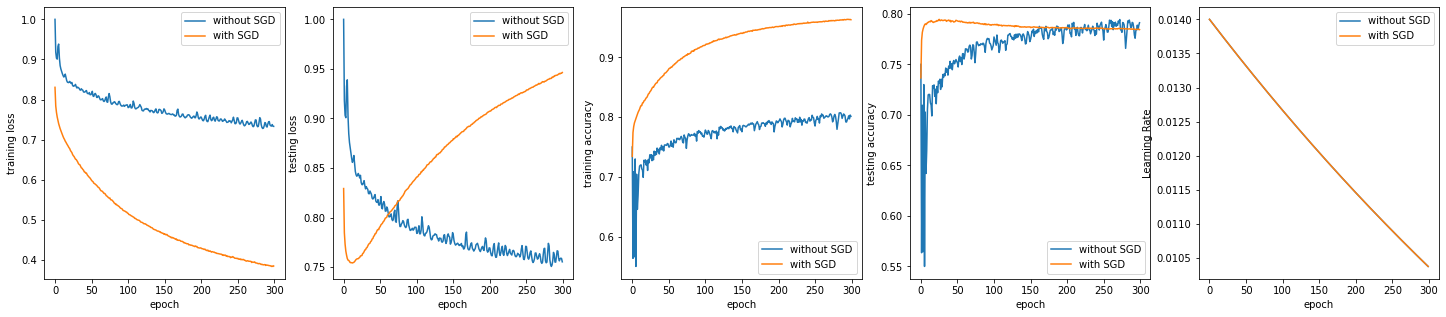

In [16]:
# ploting the graphs of training and testing losses, training and testing accuracies and learning rate

graphs([loss_history_2,loss_history_batching],[loss_history_test_2,loss_history_test_batching],[train_acc_history_2,train_acc_history_batching],[val_acc_history_2,val_acc_history_batching],[lr_array_2,lr_array_batching],"2 layer dense with SGD",compare=True,n=2,labels=["without SGD","with SGD"])

In [19]:
#part 4
x_train,y_train,x_test,y_test,K,Din,Ntr,Nte=preprocess(norm=True,reshape=False)

In [21]:
#CNN coded using Keras.models.Sequential.
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))

model.summary()

opt=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name="SGD")
model.compile(optimizer=opt,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [24]:
history=model.fit(x_train,y_train,epochs=60,batch_size=50,validation_data=(x_test,y_test))

Epoch 1/60
1000/1000 [==============================] - 41s 38ms/step - loss: 1.8724 - accuracy: 0.3047 - val_loss: 1.3846 - val_accuracy: 0.5010
Epoch 2/60
1000/1000 [==============================] - 37s 37ms/step - loss: 1.2751 - accuracy: 0.5429 - val_loss: 1.1349 - val_accuracy: 0.6001
Epoch 3/60
1000/1000 [==============================] - 37s 37ms/step - loss: 1.0848 - accuracy: 0.6148 - val_loss: 1.0718 - val_accuracy: 0.6202
Epoch 4/60
1000/1000 [==============================] - 37s 37ms/step - loss: 0.9379 - accuracy: 0.6712 - val_loss: 0.9457 - val_accuracy: 0.6730
Epoch 5/60
1000/1000 [==============================] - 37s 37ms/step - loss: 0.8397 - accuracy: 0.7053 - val_loss: 0.9510 - val_accuracy: 0.6767
Epoch 6/60
1000/1000 [==============================] - 37s 37ms/step - loss: 0.7678 - accuracy: 0.7293 - val_loss: 0.9371 - val_accuracy: 0.6778
Epoch 7/60
1000/1000 [==============================] - 38s 38ms/step - loss: 0.7018 - accuracy: 0.7544 - val_loss: 0.8553 -

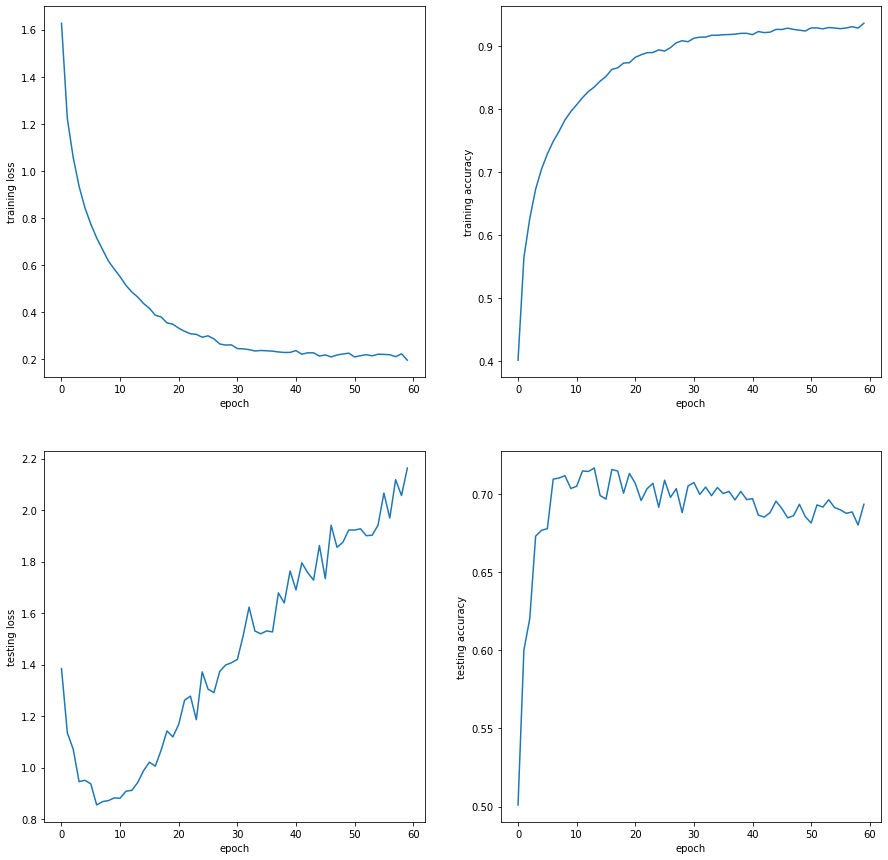

In [29]:
fig,ax=plt.subplots(2,2,figsize=(15,15))
ax[0,0].plot(history.history['loss'])
ax[0,0].set_xlabel('epoch')
ax[0,0].set_ylabel('training loss')
ax[0,1].plot(history.history['accuracy'])
ax[0,1].set_xlabel('epoch')
ax[0,1].set_ylabel('training accuracy')
ax[1,0].plot(history.history['val_loss'])
ax[1,0].set_xlabel('epoch')
ax[1,0].set_ylabel('testing loss')
ax[1,1].plot(history.history['val_accuracy'])
ax[1,1].set_xlabel('epoch')
ax[1,1].set_ylabel('testing accuracy')
plt.show()